In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

### Load data

In [2]:
people = pd.read_csv('./data_ori/people.csv', 
                     parse_dates=['date'], 
                     dtype={'people_id': np.str, 'activity_id': np.str, 'char_38': np.int32})
train = pd.read_csv('./data_ori/act_train.csv', 
                    parse_dates=['date'], 
                    dtype={'people_id': np.str, 'activity_id': np.str, 'outcome': np.int8})
test = pd.read_csv('./data_ori/act_test.csv', 
                   parse_dates=['date'], 
                   dtype={'people_id': np.str, 'activity_id': np.str})

### Preprocess data

In [3]:
def preprocess(df):
    for col in df.columns:
        if col not in ['people_id', 'activity_id', 'date', 'char_38', 'outcome']:
            if df[col].dtype == 'object':
                df[col].fillna('type 0', inplace=True)
                df[col] = df[col].apply(lambda x: x.split(' ')[1]).astype(np.int32)
            elif df[col].dtype == 'bool':
                df[col] = df[col].astype(np.int8)
    
    return df

In [4]:
for df in [people, train, test]:
    df = preprocess(df)

In [5]:
train.head()

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,4,0,0,0,0,0,0,0,0,0,76,0
1,ppl_100,act2_2434093,2022-09-27,2,0,0,0,0,0,0,0,0,0,1,0
2,ppl_100,act2_3404049,2022-09-27,2,0,0,0,0,0,0,0,0,0,1,0
3,ppl_100,act2_3651215,2023-08-04,2,0,0,0,0,0,0,0,0,0,1,0
4,ppl_100,act2_4109017,2023-08-26,2,0,0,0,0,0,0,0,0,0,1,0


In [6]:
train = pd.merge(train, people, how='left', on='people_id')
test = pd.merge(test, people, how='left', on='people_id')

In [7]:
train.shape

(2197291, 55)

In [8]:
train.sample(5)

,people_id,activity_id,date_x,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
1953473,ppl_57774,act2_1857773,2022-10-14,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2045092,ppl_73439,act2_3382518,2022-11-27,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1626004,ppl_370270,act2_1356216,2022-10-24,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
859007,ppl_245722,act2_3680947,2023-03-02,4,0,0,0,0,0,0,...,1,1,0,1,0,1,1,1,1,10
1703649,ppl_374923,act2_3863586,2022-10-07,5,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,95


### Analyse groups

In [9]:
print('Number of unique groups in train:', train.group_1.nunique())
print('Number of unique groups in test:', test.group_1.nunique())
print('Number of unique groups in test and not in train:', len(set(test.group_1)-set(train.group_1)))
print('Number of unique groups in train and not in test:', len(set(train.group_1)-set(test.group_1)))

('Number of unique groups in train:', 29899)
('Number of unique groups in test:', 11640)
('Number of unique groups in test and not in train:', 4325)
('Number of unique groups in train and not in test:', 22584)


In [10]:
grps_not_in_train = set(test.group_1)-set(train.group_1)

In [11]:
print('Number of people_id without leak',test[test.group_1.isin(grps_not_in_train)].shape)

('Number of people_id without leak', (69073, 54))


In [12]:
test['outcome']=np.nan
all_samples = pd.concat([train, test] )
all_samples.sort_values(['group_1','date_x'], inplace=True)
all_samples.index = all_samples.date_x
all_samples = all_samples[['group_1','outcome']]
all_samples['diff_o'] = all_samples.outcome.diff().abs()
all_samples['diff_g'] = all_samples.group_1.diff().abs()
all_samples.loc[all_samples.diff_g>0,'diff_o']=0

In [13]:
print('Number of unique groups:', all_samples.group_1.nunique())
print('Number of groups with mean 1:',sum(all_samples.groupby('group_1').outcome.mean()==1))
print('Number of groups with mean 0:',sum(all_samples.groupby('group_1').outcome.mean()==0))

('Number of unique groups:', 34224)
('Number of groups with mean 1:', 13049)
('Number of groups with mean 0:', 12597)


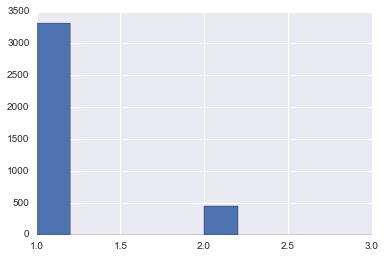

In [14]:
all_samples[all_samples.diff_o>0].groupby('group_1').sum().diff_o.hist()

In [15]:
all_samples.loc[all_samples.diff_g>0,'diff_o']=0

In [16]:
## Check dates
# date of test before min date of train
# date of train before max date of train

In [17]:
all_samples.head(30)

,group_1,outcome,diff_o,diff_g
date_x,,,,
2022-11-27,1,0.0,NaN,NaN
2022-11-27,1,0.0,0.0,0.0
2022-07-22,2,NaN,0.0,1.0
2022-08-20,2,NaN,NaN,0.0
2022-08-20,2,NaN,NaN,0.0
2022-08-27,2,NaN,NaN,0.0
2022-09-26,2,NaN,NaN,0.0
2022-09-29,2,1.0,NaN,0.0
2022-09-29,2,1.0,0.0,0.0


In [18]:
all_samples.groupby('group_1').size().sort_values()

group_1
51462         1
35074         1
35047         1
35037         1
35019         1
35012         1
35006         1
35001         1
34991         1
34988         1
4191          1
34983         1
34981         1
34978         1
35099         1
34977         1
34965         1
34955         1
4203          1
34953         1
34898         1
4209          1
34896         1
34879         1
34862         1
34822         1
4226          1
4227          1
34797         1
34973         1
          ...  
3250       2174
3702       2289
11659      2355
88         2472
17544      2551
19048      2749
1816       2813
5393       2821
418        2950
12079      2978
5149       2992
1490       3105
11143      3227
7124       3267
3229       3283
142        3638
15723      3707
9702       3848
3598       3857
1270       3918
1482       4155
7256       4528
450        4856
17899      5991
9280       6658
20472      7058
8386      10123
667       19769
27940     53668
17304    964729
dtype: int64

In [19]:
all_samples.outcome.diff()

date_x
2022-11-27    NaN
2022-11-27    0.0
2022-07-22    NaN
2022-08-20    NaN
2022-08-20    NaN
2022-08-27    NaN
2022-09-26    NaN
2022-09-29    NaN
2022-09-29    0.0
2022-09-29    0.0
2022-09-29    0.0
2022-09-29    0.0
2022-09-30    0.0
2022-09-30    0.0
2022-09-30    0.0
2022-09-30    0.0
2022-09-30    0.0
2022-09-30    0.0
2022-09-30    0.0
2022-09-30    0.0
2022-09-30    0.0
2022-09-30    0.0
2022-09-30    0.0
2022-09-30    NaN
2022-10-01    NaN
2022-10-01    0.0
2022-10-01    0.0
2022-10-01    0.0
2022-10-21    NaN
2022-10-29    NaN
             ... 
2023-08-18    0.0
2023-08-22    0.0
2023-08-22    0.0
2023-08-22    0.0
2023-08-23    0.0
2023-08-23    0.0
2023-08-23    0.0
2023-08-24    0.0
2023-08-24    0.0
2023-08-25    0.0
2023-08-25    0.0
2023-08-25    0.0
2023-08-25    0.0
2023-08-28    0.0
2023-08-30    0.0
2023-08-30    0.0
2023-08-30    0.0
2023-08-30    0.0
2023-08-30    0.0
2023-08-30    0.0
2023-08-09    0.0
2023-08-09    0.0
2023-08-09    0.0
2023-08-09    0.0
202

In [325]:
def my_interp_func(x):
    fill_if_group_not_in_train = 0.505669
    border_fill = 0.1
    
    """
    10% of groups makes one switch
    2% of groups makes two switches
    1 makes three switches
    Cases:
    a) All in train have same values (around 2/3 of groups)
        - All dates within range same value as mean
            - What if there is a large date gap? - probably not bad if t
        - What to do with dates outside range?
    b) Switch in train (around 1/3 of groups)
    """ 
    #print x.group_1[0]
    
#    if x.group_1[0]==51462:
#        print('Error ding found')
#        #x['interpolated'] = 0
#        return x
#    
#    if x.group_1[0]>51375:
#        print x.sample(1), x.shape, sum(x.outcome.isnull()), x.outcome.mean() 
#    
    
    # If 
    #if x.outcome.mean()==0:
    #    x['interpolated'] = 0
    #    return x
    
    #if x.outcome.mean()==1:
    #    x['interpolated'] = 1
    #    return x
    
    if x.shape[0]-sum(x.outcome.isnull())>0: # and x.shape[0]>2:
        x.index = x.date_x
        if 0:
            x['interpolated'] = x.outcome.interpolate(method='linear')
            x.interpolated.fillna(method='ffill', inplace=True)
            x.interpolated.fillna(method='bfill', inplace=True)
        else:
            x['ffill'] = x.outcome.fillna(method='ffill')
            x['bfill'] = x.outcome.fillna(method='bfill')
            ffill_null = x['ffill'].isnull()
            bfill_null = x['bfill'].isnull()
            x.loc[ffill_null,'ffill'] = np.abs(x.loc[ffill_null,'bfill'] - 0.1)
            x.loc[bfill_null,'bfill'] = np.abs(x.loc[bfill_null,'ffill'] - 0.1)
            x['interpolated'] = x[['ffill','bfill']].mean(axis=1).abs()
            
    else:
        x['interpolated'] = fill_if_group_not_in_train
    
    
    
    if np.random.random()>0.99:
    #    pass
         print x.sample(1), x.shape, sum(x.outcome.isnull()), x.outcome.mean(), x.interpolated.mean()  
        
    return x.reset_index(drop=True)

In [328]:
def kaggle_interp_func(x):
    x = x.reset_index(drop=True)
    g = x['outcome'].copy() ## g should be a list or a pandas Series.
    if g.shape[0] < 3: ## If we have at most two rows.
        x['filled'] = g ## Will be replaced by a mean.
        return x
    
    missing_index = g.isnull()
    
    if sum(missing_index)==g.shape[0]: # if no train data is available
        x['filled'] = 0.505669
        return x
    borders = np.append([g.index[0]], g[~missing_index].index, axis=0)
    borders = np.append(borders, [g.index[-1]+1], axis=0)
    forward_border = borders[1:]
    backward_border = borders[:-1]
    forward_border_g = g[forward_border]
    backward_border_g = g[backward_border]
    ## Interpolate borders.
    ## TODO: Why does the script author use the value 0.1?
    border_fill = 0.1
    forward_border_g[forward_border_g.index[-1]] = abs(forward_border_g[forward_border_g.index[-2]]-border_fill)
    backward_border_g[backward_border_g.index[0]] = abs(forward_border_g[forward_border_g.index[0]]-border_fill)
    times = forward_border-backward_border
    forward_x_fill = np.repeat([forward_border_g], times)#.reset_index(drop=True)
    backward_x_fill = np.repeat([backward_border_g], times)#.reset_index(drop=True)
    vec = (forward_x_fill+backward_x_fill)/2
    g[missing_index] = vec[g[missing_index].index] ## Impute missing values only.
    x['filled'] = g
    return x
    

In [329]:
tr_x = train[train.group_1==gid]
te_x = test[test.group_1==gid]
if te_x.shape[0]>0:
    
    te_x.loc[:,'outcome'] = np.nan
    x = pd.concat([tr_x, te_x] )
else:
    print('No test data')
    x = tr_x
#x.index = x.date_x
x.sort_values('date_x',inplace=True)
x = x[['outcome','date_x']]


x = my_interp_func(x)
x = kaggle_interp_func(x)
x.index = x.date_x

In [330]:
print('Test shape', te_x.shape)
print('Train shape', tr_x.shape)
print('X shape', x.shape)
x.head(10)

('Test shape', (43, 55))
('Train shape', (0, 55))
('X shape', (43, 4))


,outcome,date_x,interpolated,filled
date_x,,,,
2022-07-21,NaN,2022-07-21,0.505669,0.505669
2022-07-23,NaN,2022-07-23,0.505669,0.505669
2022-08-02,NaN,2022-08-02,0.505669,0.505669
2022-08-18,NaN,2022-08-18,0.505669,0.505669
2022-08-25,NaN,2022-08-25,0.505669,0.505669
2022-09-02,NaN,2022-09-02,0.505669,0.505669
2022-09-02,NaN,2022-09-02,0.505669,0.505669
2022-09-15,NaN,2022-09-15,0.505669,0.505669
2022-09-23,NaN,2022-09-23,0.505669,0.505669


In [331]:
test[test.activity_id=='act2_3406471'][['group_1','date_x']]

,group_1,date_x
396366,19844,2023-02-09


In [332]:
gid=19844
print('Test shape', test[test.group_1==gid].shape)
print('Train shape', train[train.group_1==gid].shape)

('Test shape', (43, 55))
('Train shape', (0, 55))


In [336]:
tr_x = train[train.group_1==gid]
te_x = test[test.group_1==gid]
if te_x.shape[0]>0:
    
    te_x.loc[:,'outcome'] = np.nan
    x = pd.concat([tr_x, te_x] )
else:
    print('Test empty')
    x = tr_x
#x.index = x.date_x
x.sort_values('date_x',inplace=True)
x = x[['outcome','date_x']]

x = my_interp_func(x)
x = kaggle_interp_func(x)
x['diffe'] = x['interpolated']-x['filled']
x.index = x.date_x

In [337]:
x.head(130)

,outcome,date_x,interpolated,filled,diffe
date_x,,,,,
2022-07-21,NaN,2022-07-21,0.505669,0.505669,0.0
2022-07-23,NaN,2022-07-23,0.505669,0.505669,0.0
2022-08-02,NaN,2022-08-02,0.505669,0.505669,0.0
2022-08-18,NaN,2022-08-18,0.505669,0.505669,0.0
2022-08-25,NaN,2022-08-25,0.505669,0.505669,0.0
2022-09-02,NaN,2022-09-02,0.505669,0.505669,0.0
2022-09-02,NaN,2022-09-02,0.505669,0.505669,0.0
2022-09-15,NaN,2022-09-15,0.505669,0.505669,0.0
2022-09-23,NaN,2022-09-23,0.505669,0.505669,0.0


TypeError: Empty 'DataFrame': no numeric data to plot

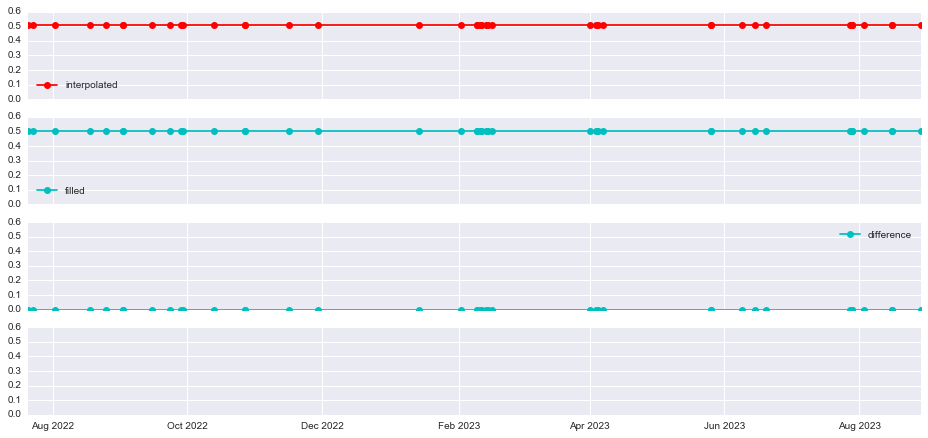

In [338]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(16,8), sharey=True)
x.plot(y='interpolated',marker='o', color='r', label='interpolated', ax=ax1)
x.plot(y='filled',marker='o', color='c', label='filled', ax=ax2)
x.plot(y='diffe',marker='o', color='c', label='difference', ax=ax3)
train[train.group_1==gid].plot(x='date_x',y='outcome',marker='o', label='train', ax=ax4)
if te_x.shape[0]>0:
    te_x['outcome'] = 0.5
    te_x.plot(x='date_x',y='outcome', marker='o', color='g', ax=ax4, label='test')
ax1.set_ylim([-0.1,1.1])


### Code from Kaggle

In [207]:
x = x.reset_index(drop=True)
g = x['outcome'].copy() ## g should be a list or a pandas Series.
if g.shape[0] < 3: ## If we have at most two rows.
    x['filled'] = g ## Will be replaced by a mean.
print g.values

[  0.   0.  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan   1.   1.   1.   1.   1.   1.  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan   1.  nan   1.   1.
   1.  nan  nan  nan  nan  nan   1.  nan  nan  nan  nan  nan  nan   1.  nan
   1.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan]


In [210]:
missing_index = g.isnull()
print missing_index.values

[False False  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True False
 False False False False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True False False False  True  True  True  True  True
 False  True  True  True  True  True  True False  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]


In [211]:
# Borders contain element numbers of not missing values, plus the first index and the last index + 1
borders = np.append([g.index[0]], g[~missing_index].index, axis=0)
borders = np.append(borders, [g.index[-1]+1], axis=0)
print borders

[  0   0   1  11  23  24  25  26  27  28  86  88  89  90  96 103 105 144]


In [212]:
# Forward border contains outcome values for training samples starting from second element, excluding last
forward_border = borders[1:]
forward_border_g = g[forward_border]
forward_border_g.index

Int64Index([0, 1, 11, 23, 24, 25, 26, 27, 28, 86, 88, 89, 90, 96, 103, 105,
            144],
           dtype='int64')

In [213]:
# Backward border contains values for training samples starting from second element, including last
backward_border = borders[:-1]
backward_border_g = g[backward_border]
backward_border_g.index.values

array([  0,   0,   1,  11,  23,  24,  25,  26,  27,  28,  86,  88,  89,
        90,  96, 103, 105])

In [214]:
border_fill = 0.1

In [215]:
# Manually set first and last element of forward border and backward border
forward_border_g[forward_border_g.index[-1]] = abs(forward_border_g[forward_border_g.index[-2]]-border_fill)
backward_border_g[backward_border_g.index[0]] = abs(forward_border_g[forward_border_g.index[0]]-border_fill)

In [216]:
print forward_border
print backward_border
times = forward_border-backward_border
times

[  0   1  11  23  24  25  26  27  28  86  88  89  90  96 103 105 144]
[  0   0   1  11  23  24  25  26  27  28  86  88  89  90  96 103 105]


array([ 0,  1, 10, 12,  1,  1,  1,  1,  1, 58,  2,  1,  1,  6,  7,  2, 39])

In [217]:
forward_x_fill = np.repeat([forward_border_g], times)#.reset_index(drop=True)
print forward_x_fill

[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9]


In [218]:
backward_x_fill = np.repeat([backward_border_g], times)#.reset_index(drop=True)
print backward_x_fill

[ 0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1. ]


In [219]:
vec = (forward_x_fill+backward_x_fill)/2
print vec

[ 0.05  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.5
  0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95
  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95
  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95
  0.95  0.95  0.95  0.95  0.95]


In [224]:
print g[missing_index].index
print vec[g[missing_index].index]

Int64Index([  2,   3,   4,   5,   6,   7,   8,   9,  10,  12,
            ...
            134, 135, 136, 137, 138, 139, 140, 141, 142, 143],
           dtype='int64', length=128)
[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.5   0.5   0.5
  0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95
  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95
  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95
  0.95  0.95]


In [178]:
g[missing_index] = vec[missing_index] ## Impute missing values only.
x['filled'] = g

/Users/joostbloom/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  if __name__ == '__main__':


In [179]:
print x.filled.values

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.
  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


### Try to run on all groups

In [144]:
def guess_outcome(x):
    
    fill_if_group_not_in_train = 0.5
    
    """
    10% of groups makes one switch
    2% of groups makes two switches
    1 makes three switches
    Cases:
    a) All in train have same values (around 2/3 of groups)
        - All dates within range same value as mean
            - What if there is a large date gap? - probably not bad if t
        - What to do with dates outside range?
    b) Switch in train (around 1/3 of groups)
    """ 
    #print x.group_1[0]
    
#    if x.group_1[0]==51462:
#        print('Error ding found')
#        #x['interpolated'] = 0
#        return x
#    
#    if x.group_1[0]>51375:
#        print x.sample(1), x.shape, sum(x.outcome.isnull()), x.outcome.mean() 
#    
    
    # If 
    if x.outcome.mean()==0:
        x['interpolated'] = 0
        return x
    
    if x.outcome.mean()==1:
        x['interpolated'] = 1
        return x
    
    if x.shape[0]-sum(x.outcome.isnull())>1: # and x.shape[0]>2:
        x.index = x.date_x
        x['interpolated'] = x.outcome.interpolate(method='nearest')
        x.interpolated.fillna(method='ffill', inplace=True)
        x.interpolated.fillna(method='bfill', inplace=True)
    else:
        x['interpolated'] = fill_if_group_not_in_train
    
    
    
    #if np.random.random()>0.95 or x.group_1[0]>51375:
    #    pass
    #    #print x.sample(1), x.shape, sum(x.outcome.isnull()), x.outcome.mean(), x.interpolated.mean()  
        
    return x.reset_index(drop=True)

In [140]:
all_samples.index.nunique()

2197291

In [141]:
all_samples = x = pd.concat([train, test] )
all_samples.sort_values(['group_1','date_x'], inplace=True)
#all_samples.index = all_samples.date_x
all_samples = all_samples[['group_1','outcome','date_x']]

In [142]:
all_samples[all_samples.group_1.isin([8,10])]

,group_1,outcome,date_x
1895484,8,1.0,2022-07-26
1895515,8,1.0,2022-07-28
1895502,8,1.0,2022-07-29
1895459,8,1.0,2022-08-03
1895460,8,1.0,2022-08-04
1895463,8,1.0,2022-08-04
1895472,8,1.0,2022-08-04
1895474,8,1.0,2022-08-04
1895482,8,1.0,2022-08-04
1895487,8,1.0,2022-08-04


In [147]:
all_samples[all_samples.group_1.isin([8,10])].groupby('group_1').apply(guess_outcome).reset_index(drop=True)

,group_1,outcome,date_x,interpolated
0,8,1.0,2022-07-26,1.0
1,8,1.0,2022-07-28,1.0
2,8,1.0,2022-07-29,1.0
3,8,1.0,2022-08-03,1.0
4,8,1.0,2022-08-04,1.0
5,8,1.0,2022-08-04,1.0
6,8,1.0,2022-08-04,1.0
7,8,1.0,2022-08-04,1.0
8,8,1.0,2022-08-04,1.0
9,8,1.0,2022-08-04,1.0


In [73]:
def guess_outcome(x):
    
    fill_if_group_not_in_train = 0.5
    
    if x.shape[0]-sum(x.outcome.isnull())>1: # and x.shape[0]>2:
        x['interpolated'] = x.outcome.interpolate(method='nearest')
        x.interpolated.fillna(method='ffill', inplace=True)
        x.interpolated.fillna(method='bfill', inplace=True)
    else:
        x['interpolated'] = fill_if_group_not_in_train
    
    
    print x.sample(1), x.shape, sum(x.outcome.isnull()), x.outcome.mean(), x.interpolated.mean()
    return x

In [74]:
test['outcome']=np.nan

In [75]:
all_samples = x = pd.concat([train, test] )
all_samples.index = all_samples.date_x
all_samples = all_samples[['group_1','outcome']]

In [76]:
all_samples.head()

,group_1,outcome
date_x,,
2023-08-26,17304,0.0
2022-09-27,17304,0.0
2022-09-27,17304,0.0
2023-08-04,17304,0.0
2023-08-26,17304,0.0


In [ ]:
all_samples.groupby('group_1').apply(guess_outcome)

            group_1  outcome  interpolated
date_x                                    
2022-11-27        1      0.0           0.0 (2, 3) 0 0.0 0.0
            group_1  outcome  interpolated
date_x                                    
2022-11-27        1      0.0           0.0 (2, 3) 0 0.0 0.0
            group_1  outcome  interpolated
date_x                                    
2022-12-28        2      1.0           1.0 (95, 3) 51 1.0 1.0
            group_1  outcome  interpolated
date_x                                    
2023-03-24        3      1.0           1.0 (47, 3) 10 1.0 1.0
            group_1  outcome  interpolated
date_x                                    
2023-08-30        4      1.0           1.0 (80, 3) 17 1.0 1.0
            group_1  outcome  interpolated
date_x                                    
2023-01-24        5      1.0           1.0 (262, 3) 0 1.0 1.0
            group_1  outcome  interpolated
date_x                                    
2023-04-13        6      1.0  

KeyboardInterrupt: 

In [ ]:
x=1

In [31]:
train.columns

Index([u'people_id', u'activity_id', u'date_x', u'activity_category',
       u'char_1_x', u'char_2_x', u'char_3_x', u'char_4_x', u'char_5_x',
       u'char_6_x', u'char_7_x', u'char_8_x', u'char_9_x', u'char_10_x',
       u'outcome', u'char_1_y', u'group_1', u'char_2_y', u'date_y',
       u'char_3_y', u'char_4_y', u'char_5_y', u'char_6_y', u'char_7_y',
       u'char_8_y', u'char_9_y', u'char_10_y', u'char_11', u'char_12',
       u'char_13', u'char_14', u'char_15', u'char_16', u'char_17', u'char_18',
       u'char_19', u'char_20', u'char_21', u'char_22', u'char_23', u'char_24',
       u'char_25', u'char_26', u'char_27', u'char_28', u'char_29', u'char_30',
       u'char_31', u'char_32', u'char_33', u'char_34', u'char_35', u'char_36',
       u'char_37', u'char_38'],
      dtype='object')

In [33]:
train.group_1.nunique()

11640

In [35]:
len(set(train.group_1) & set(test.group_1))

7315

In [40]:
train.set_index(train.activity_id, inplace=True)
test.set_index(test.activity_id, inplace=True)
train.head()

,people_id,activity_id,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,...,char_33,char_34,char_35,char_36,char_37,char_38,year_y,month_y,day_y,isweekend_y
activity_id,,,,,,,,,,,,,,,,,,,,,
act2_1734928,ppl_100,act2_1734928,4,0,0,0,0,0,0,0,...,0,1,1,1,0,36,2021,6,29,0
act2_2434093,ppl_100,act2_2434093,2,0,0,0,0,0,0,0,...,0,1,1,1,0,36,2021,6,29,0
act2_3404049,ppl_100,act2_3404049,2,0,0,0,0,0,0,0,...,0,1,1,1,0,36,2021,6,29,0
act2_3651215,ppl_100,act2_3651215,2,0,0,0,0,0,0,0,...,0,1,1,1,0,36,2021,6,29,0
act2_4109017,ppl_100,act2_4109017,2,0,0,0,0,0,0,0,...,0,1,1,1,0,36,2021,6,29,0


In [41]:
test.head()

,people_id,activity_id,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,...,char_33,char_34,char_35,char_36,char_37,char_38,year_y,month_y,day_y,isweekend_y
activity_id,,,,,,,,,,,,,,,,,,,,,
act1_249281,ppl_100004,act1_249281,1,5,10,5,1,6,1,1,...,1,1,1,1,1,76,2022,7,20,0
act2_230855,ppl_100004,act2_230855,5,0,0,0,0,0,0,0,...,1,1,1,1,1,76,2022,7,20,0
act1_240724,ppl_10001,act1_240724,1,12,1,5,4,6,1,1,...,1,1,1,1,1,90,2022,10,14,0
act1_83552,ppl_10001,act1_83552,1,20,10,5,4,6,1,1,...,1,1,1,1,1,90,2022,10,14,0
act2_1043301,ppl_10001,act2_1043301,5,0,0,0,0,0,0,0,...,1,1,1,1,1,90,2022,10,14,0


In [42]:
train.columns

Index([u'people_id', u'activity_id', u'activity_category', u'char_1_x',
       u'char_2_x', u'char_3_x', u'char_4_x', u'char_5_x', u'char_6_x',
       u'char_7_x', u'char_8_x', u'char_9_x', u'char_10_x', u'outcome',
       u'year_x', u'month_x', u'day_x', u'isweekend_x', u'char_1_y',
       u'group_1', u'char_2_y', u'char_3_y', u'char_4_y', u'char_5_y',
       u'char_6_y', u'char_7_y', u'char_8_y', u'char_9_y', u'char_10_y',
       u'char_11', u'char_12', u'char_13', u'char_14', u'char_15', u'char_16',
       u'char_17', u'char_18', u'char_19', u'char_20', u'char_21', u'char_22',
       u'char_23', u'char_24', u'char_25', u'char_26', u'char_27', u'char_28',
       u'char_29', u'char_30', u'char_31', u'char_32', u'char_33', u'char_34',
       u'char_35', u'char_36', u'char_37', u'char_38', u'year_y', u'month_y',
       u'day_y', u'isweekend_y'],
      dtype='object')

In [43]:
y = train['outcome']
train.drop('outcome', axis=1, inplace=True)

In [44]:
col_drop = ['people_id','activity_id']
train.drop(col_drop, axis=1, inplace=True)
test.drop(col_drop, axis=1, inplace=True)

In [47]:
def reduce_dimen(dataset,column,toreplace):
    for index,i in dataset[column].duplicated(keep=False).iteritems():
        if i==False:
            dataset.set_value(index,column,toreplace)
    return dataset

In [48]:
categorical=['group_1','activity_category','char_1_x','char_2_x','char_3_x','char_4_x','char_5_x','char_6_x','char_7_x','char_8_x','char_9_x','char_2_y','char_3_y','char_4_y','char_5_y','char_6_y','char_7_y','char_8_y','char_9_y']

In [49]:
for category in categorical:
    train=reduce_dimen(train,category,9999999)
    test=reduce_dimen(test,category,9999999)

In [50]:
not_categorical=[]
for category in train.columns:
    if category not in categorical:
        not_categorical.append(category)

In [54]:
enc = OneHotEncoder(handle_unknown='ignore')
enc=enc.fit(pd.concat([train[categorical],test[categorical]]))
X_cat_sparse=enc.transform(train[categorical])
X_test_cat_sparse=enc.transform(test[categorical])

In [55]:
from scipy.sparse import hstack
X_sparse=hstack((train[not_categorical], X_cat_sparse))
X_test_sparse=hstack((test[not_categorical], X_test_cat_sparse))

In [56]:
print("Training data: " + format(X_sparse.shape))
print("Test data: " + format(X_test_sparse.shape))

Training data: (2197291, 31193)
Test data: (498687, 31193)


In [57]:
import xgboost as xgb
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [58]:
print("###########")
print("One Hot enconded Test Dataset Script")

dtrain = xgb.DMatrix(X_sparse,label=y)
dtest = xgb.DMatrix(X_test_sparse)

param = {'max_depth':10, 'eta':0.02, 'silent':1, 'objective':'binary:logistic' }
param['nthread'] = 4
param['eval_metric'] = 'auc'
param['subsample'] = 0.7
param['colsample_bytree']= 0.7
param['min_child_weight'] = 0
param['booster'] = "gblinear"

watchlist  = [(dtrain,'train')]
num_round = 300
early_stopping_rounds=10
bst = xgb.train(param, dtrain, num_round, watchlist,early_stopping_rounds=early_stopping_rounds)

ypred = bst.predict(dtest)

###########
One Hot enconded Test Dataset Script


Will train until train error hasn't decreased in 10 rounds.
[0]	train-auc:0.888151
[1]	train-auc:0.895634
[2]	train-auc:0.903430
[3]	train-auc:0.911554
[4]	train-auc:0.919667
[5]	train-auc:0.927478
[6]	train-auc:0.934775
[7]	train-auc:0.941507
[8]	train-auc:0.947791
[9]	train-auc:0.953636
[10]	train-auc:0.959022
[11]	train-auc:0.963911
[12]	train-auc:0.968259
[13]	train-auc:0.972061
[14]	train-auc:0.975334
[15]	train-auc:0.978118
[16]	train-auc:0.980467
[17]	train-auc:0.982441
[18]	train-auc:0.984091
[19]	train-auc:0.985470
[20]	train-auc:0.986625
[21]	train-auc:0.987597
[22]	train-auc:0.988422
[23]	train-auc:0.989131
[24]	train-auc:0.989745
[25]	train-auc:0.990285
[26]	train-auc:0.990765
[27]	train-auc:0.991193
[28]	train-auc:0.991579
[29]	train-auc:0.991929
[30]	train-auc:0.992249
[31]	train-auc:0.992541
[32]	train-auc:0.992809
[33]	train-auc:0.993055
[34]	train-auc:0.993282
[35]	train-auc:0.993492
[36]	train-auc:0.993686
[37]	train-auc:0.993867
[38]	train-auc:0.994036
[39]	train-auc

KeyError: 'activity_id'

In [60]:
from ml_toolbox.kaggle import KaggleResult

In [62]:
kag = KaggleResult(ypred, test.index.values, 0.997242, 'test2', 'test2')

In [63]:
print kag.validate()

(True, 'all_ok')


In [64]:
kag.upload()

0.978699